In [1]:
!pip install pip install mdlp-discretization

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import pickle
import os
import numpy as np
from mdlp.discretization import MDLP
os.chdir("D:\\GoogleDrive\\InterviewAssignment\\GoJekDriverAcceptanceGit\\GoJekAssignment")

## Here we are using all Data 

In [4]:
train  = pd.read_csv("data\\processed\\dataset.csv")
train_filtered = train[train["participant_status"] != "CREATED"]
train_filtered.loc[:,"event_timestamp"] = pd.to_datetime(train_filtered["event_timestamp"], infer_datetime_format=True).dt.tz_convert('Asia/Kolkata')
train_filtered.loc[:,"date"] = train_filtered.event_timestamp.dt.date
train_filtered.loc[:,"dayofweek"] = train_filtered.event_timestamp.dt.dayofweek
train_filtered.loc[:,"hourofday"] = train_filtered.event_timestamp.dt.hour
#train_filtered = train_filtered.sort_values(by = ['driver_id', 'date'])

<font size="4">  Mean aceeptance rate of rides for various day of week  in general seems to be same though on weekend it seems to fall </font>

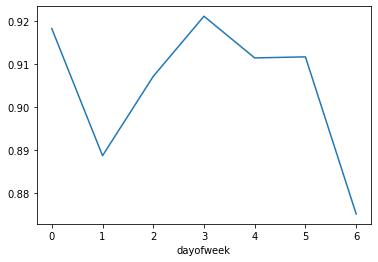

In [5]:
train_filtered.groupby("dayofweek")['is_accepted'].mean().plot()

<font size="4">Mean aceeptance rate of rides for different hours seems to vary especially during late night it drops signficantly</font>

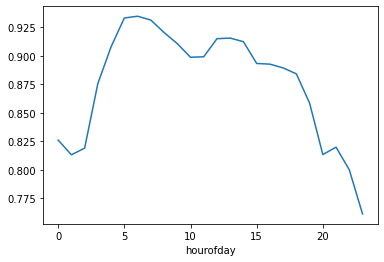

In [6]:
train_filtered.groupby("hourofday")['is_accepted'].mean().plot()

<font size="3"> Total Variance between the drivers behaviour in accepting rides on different timestamps we have to model this at driver level to find out which driver is more likely to accept given day, hour </font>

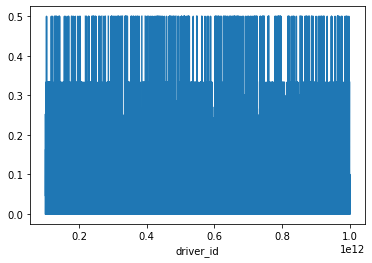

In [7]:
train_filtered.groupby("driver_id")["is_accepted"].var().plot()

In [8]:
train.event_timestamp.min(),train.event_timestamp.max()

('2015-05-10 00:00:11.845 UTC', '2015-05-18 23:59:59.632 UTC')

In [9]:
test.event_timestamp.min(),test.event_timestamp.max()

('2015-05-20 00:00:18.427 UTC', '2015-05-20 23:59:58.789 UTC')

<font size="4"> Are there any drivers which are new in test ?? We will have to think about them while creating driver specific features </font>

In [10]:
set(test.driver_id) - set(train.driver_id)

{100664838380,
 101583365707,
 103299629464,
 103800972668,
 104604639756,
 105545310230,
 105705609117,
 107308382211,
 107551420935,
 108717286399,
 110865803710,
 111221883793,
 114985207100,
 117081749451,
 117820403375,
 124967161000,
 125854011970,
 129631451499,
 130968242684,
 131081133301,
 131492558934,
 134147873938,
 134989520765,
 135542477670,
 137971307735,
 138114638521,
 146221502981,
 151058256284,
 154495051688,
 155972704680,
 155996123208,
 158774538657,
 163835024838,
 163991680290,
 164468712994,
 165096574645,
 165709957694,
 169258789164,
 170871467494,
 170886269015,
 171269899618,
 175962875950,
 176277677303,
 176614303750,
 176962363668,
 177382736915,
 177794034400,
 177839920162,
 179006878394,
 179712738760,
 181798466661,
 182870616479,
 184956889830,
 185883344873,
 186562630108,
 186635044905,
 186726080670,
 187071586534,
 188949205236,
 190738016217,
 190912486291,
 191558520622,
 192485896191,
 193931556742,
 197038127841,
 198577398178,
 199702155

<font size="4"> Creating General Participant Features </font>

In [11]:
dayofweek_average = train_filtered.groupby("dayofweek")['is_accepted'].mean().reset_index().rename(columns = {'is_accepted':'dayofweek_average'})
hourofday_average = train_filtered.groupby("hourofday")['is_accepted'].mean().reset_index().rename(columns = {'is_accepted':'hourofday_average'})

In [12]:
train_filtered = train_filtered.merge(dayofweek_average,on="dayofweek",how='right')\
                            .merge(hourofday_average,on="hourofday",how='right')

<font size="4"> Driver Specific Features </font>

In [13]:
driver_last5day_rolling_mean = train_filtered.groupby(['driver_id','date'])\
                                             .agg({'is_accepted':'mean'})\
                                             .groupby(level=0, group_keys=False)\
                                             .rolling(5, min_periods = 1)\
                                             .mean().reset_index()

driver_last5day_rolling_mean = driver_last5day_rolling_mean.rename(columns = {'is_accepted':'is_accepted_last5day_rolling_mean'})

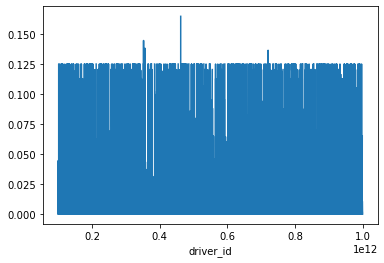

In [14]:
driver_last5day_rolling_mean.groupby("driver_id")['is_accepted_last5day_rolling_mean'].var().plot()

<font size="3"> Capturing variance in acceptance behaviour of different drivers on different day of week </font>

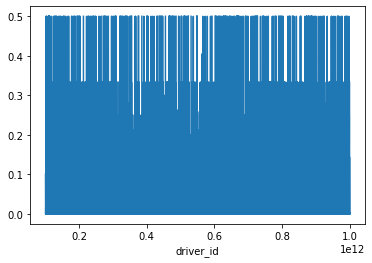

In [15]:
driver_last2dayofweek_average = train_filtered.groupby(["driver_id","date"],as_index=False)\
        .agg({'is_accepted': 'mean', 'dayofweek': 'first'}).reset_index()\
        .groupby(["driver_id","dayofweek"])["is_accepted"] \
        .apply(lambda x: x.tail(2).mean()).reset_index()

driver_last2dayofweek_average = driver_last2dayofweek_average.rename(columns= {'is_accepted':'driver_dayofweek_average'})

driver_last2dayofweek_average = driver_last2dayofweek_average.pivot('driver_id','dayofweek','driver_dayofweek_average').stack(dropna=False).reset_index(name='driver_dayofweek_average')

driver_last2dayofweek_average.groupby("driver_id")["driver_dayofweek_average"].var().plot()

driver_last2dayofweek_average['driver_dayofweek_average'].fillna(driver_last2dayofweek_average.groupby('driver_id')['driver_dayofweek_average'].transform('mean'),inplace = True)

<font size="3"> Capturing variance in acceptance behaviour of different drivers on different hour of day </font>

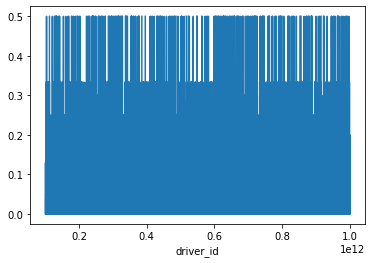

In [16]:
driver_hourofday_average = train_filtered.groupby(["driver_id","hourofday"],as_index=False).agg({'is_accepted': 'mean'}).rename(columns= {'is_accepted':'driver_hourofday_average'})
driver_hourofday_average = driver_hourofday_average.pivot('driver_id','hourofday','driver_hourofday_average').stack(dropna=False).reset_index(name='driver_hourofday_average')
driver_hourofday_average.groupby("driver_id")["driver_hourofday_average"].var().plot()
driver_hourofday_average['driver_hourofday_average'].fillna(driver_hourofday_average.groupby('driver_id')['driver_hourofday_average'].transform('mean'),inplace = True)

In [17]:
dayofweek_features = driver_last2dayofweek_average.merge(dayofweek_average,on="dayofweek",how="outer")
hourofday_features = driver_hourofday_average.merge(hourofday_average,on="hourofday",how="outer")
last5day_features = driver_last5day_rolling_mean

<font size="4">  Entropy based discretisation of hours on the basis of acceptance and number of request based binning on traffic volumne </font>

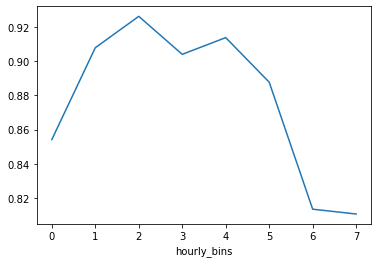

In [18]:
transformer = MDLP(continuous_features=[True])
train_filtered['hourly_bins'] = transformer.fit_transform(np.array(train_filtered['hourofday']).reshape(-1, 1), train_filtered['is_accepted'])
train_filtered.groupby('hourly_bins')['is_accepted'].mean().plot()
pickle.dump(transformer, open('transformer.pkl', 'wb'))

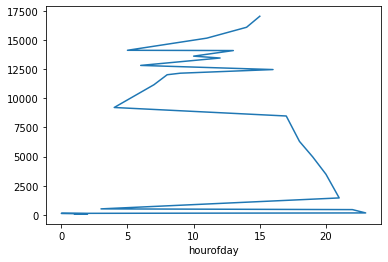

In [19]:
train_filtered.groupby('hourofday').size().sort_values(ascending=False).plot()
train_filtered["is_busy_hour"] = train_filtered["hourofday"].apply(lambda x:  1 if x>=5 and x<=15 else 0)

In [20]:
dayofweek_features.to_csv("dayofweek_features.csv")
hourofday_features.to_csv("hourofday_features.csv")
last5day_features.to_csv("last5day_features.csv")